# Anexo: Prueba de Linealidad y Análisis SHAP

Notebook para validación de supuestos estadísticos y análisis de interpretabilidad mediante SHAP Values.

## Contenido:
1. **Configuración y carga de datos limpios**
2. **Preparación de features** (codificación, imputación, escalado)
3. **Prueba de linealidad** (Rainbow, RESET, Harvey-Collier) - Validación de supuestos para regresión
4. **Análisis SHAP** - Interpretabilidad avanzada del mejor modelo

**Dataset:** `datos/saber_11_limpio_final.csv` (excluyendo puntajes de áreas específicas)

**Nota:** Este notebook contiene únicamente las pruebas de validación y análisis de interpretabilidad. 
El modelado predictivo completo se encuentra en `Modelos.ipynb`.

In [39]:
# Configuracion e imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow, linear_reset, linear_harvey_collier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

plt.style.use('seaborn-v0_8-whitegrid')

BASE_DIR = Path('.')
DATA_PATH = BASE_DIR / 'datos' / 'saber_11_limpio_final.csv'
OUTPUT_DIR = BASE_DIR / 'artifacts' / 'anexos'
TARGET_COL = 'punt_global'
PUNTAJES_ESPECIFICOS = ['punt_lectura_critica','punt_matematicas','punt_c_naturales','punt_sociales_ciudadanas','punt_ingles','desemp_ingles']
ID_COLS = ['estu_consecutivo','estu_estudiante','periodo','__archivo']

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Ruta de datos: {DATA_PATH.resolve()}')
print(f'Directorio de salida: {OUTPUT_DIR.resolve()}')


Ruta de datos: C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\datos\saber_11_limpio_final.csv
Directorio de salida: C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\artifacts\anexos


In [40]:
# Carga de datos
print('=== Carga de datos limpios ===')
df = pd.read_csv(DATA_PATH)
print(f'Filas: {len(df):,} | Columnas: {len(df.columns)}')
if TARGET_COL not in df.columns:
    raise ValueError(f'Falta la columna objetivo {TARGET_COL}')
display(df.head())


=== Carga de datos limpios ===
Filas: 217,335 | Columnas: 47
Filas: 217,335 | Columnas: 47


C:\Users\Saramirezm\AppData\Local\Temp\ipykernel_27996\1460826824.py:3: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,periodo,estu_consecutivo,estu_estudiante,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,...,punt_global,punt_lectura_critica,punt_sociales_ciudadanas,fami_numlibros,estu_tieneetnia,estu_discapacidad,estu_repite,municipio,anio,p
0,20192,SB11201940509244,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,217.0,48,39,0 A 10 LIBROS,No,N,0,SANTA MARTA,2019,2
1,20242,SB11202430140809,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,TARDE,OFICIAL,...,241.0,53,37,0 A 10 LIBROS,NO APLICA,N,0,SANTA MARTA,2024,2
2,20242,SB11202430444482,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,187.0,37,29,11 A 25 LIBROS,NO APLICA,N,0,SANTA MARTA,2024,2
3,20242,SB11202430495484,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,188.0,42,38,NO APLICA,NO APLICA,N,0,SANTA MARTA,2024,2
4,20202,SB11202040541194,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,TARDE,OFICIAL,...,250.0,54,53,0 A 10 LIBROS,No,N,0,SANTA MARTA,2020,2


In [41]:
# Exclusion de puntajes especificos y columnas de identificacion
print('=== Exclusion de puntajes especificos ===')
df_contexto = df.drop(columns=[c for c in PUNTAJES_ESPECIFICOS if c in df.columns])
print(f'Columnas eliminadas: {len(df.columns) - len(df_contexto.columns)}')
display(df_contexto.head())


=== Exclusion de puntajes especificos ===
Columnas eliminadas: 6


,periodo,estu_consecutivo,estu_estudiante,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,...,estu_grado,fami_tieneserviciotv,punt_global,fami_numlibros,estu_tieneetnia,estu_discapacidad,estu_repite,municipio,anio,p
0,20192,SB11201940509244,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,11,Si,217.0,0 A 10 LIBROS,No,N,0,SANTA MARTA,2019,2
1,20242,SB11202430140809,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,TARDE,OFICIAL,...,11,Si,241.0,0 A 10 LIBROS,NO APLICA,N,0,SANTA MARTA,2024,2
2,20242,SB11202430444482,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,26,No,187.0,11 A 25 LIBROS,NO APLICA,N,0,SANTA MARTA,2024,2
3,20242,SB11202430495484,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,26,No,188.0,NO APLICA,NO APLICA,N,0,SANTA MARTA,2024,2
4,20202,SB11202040541194,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,TARDE,OFICIAL,...,11,Si,250.0,0 A 10 LIBROS,No,N,0,SANTA MARTA,2020,2


In [42]:
# Preparacion de features (codificacion y imputacion)
def preparar_features(df_in: pd.DataFrame):
    df_model = df_in.drop(columns=[c for c in ID_COLS if c in df_in.columns])
    X = df_model.drop(columns=[TARGET_COL])
    y = df_model[TARGET_COL]
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    X_encoded = X.copy()
    encoders: Dict[str, LabelEncoder] = {}
    for col in categorical_features:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].fillna('MISSING').astype(str))
        encoders[col] = le
    imputer = SimpleImputer(strategy='median')
    X_encoded[numeric_features] = imputer.fit_transform(X_encoded[numeric_features])
    return X_encoded, y, numeric_features, categorical_features

X_encoded, y, numeric_features, categorical_features = preparar_features(df_contexto)
print(f'Vars numericas: {len(numeric_features)} | Categoricas: {len(categorical_features)}')
display(X_encoded.head())


Vars numericas: 2 | Categoricas: 34


,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,estu_depto_presentacion,estu_depto_reside,estu_fechanacimiento,...,estu_agregado,estu_grado,fami_tieneserviciotv,fami_numlibros,estu_tieneetnia,estu_discapacidad,estu_repite,municipio,anio,p
0,2,0,0,0,2,2,2,0,20,2441,...,1,0,2,0,1,0,0,1,2019.0,2.0
1,2,0,0,0,2,5,2,0,20,3831,...,1,0,2,0,0,0,0,1,2024.0,2.0
2,2,0,0,0,2,2,2,0,20,4735,...,1,3,1,1,0,0,0,1,2024.0,2.0
3,2,0,0,0,2,2,2,0,20,3561,...,1,3,1,4,0,0,0,1,2024.0,2.0
4,2,0,0,0,2,5,2,0,20,939,...,1,0,2,0,1,0,0,1,2020.0,2.0


In [43]:
# Split train/test y escalado
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')


X_train: (173868, 36), X_test: (43467, 36)


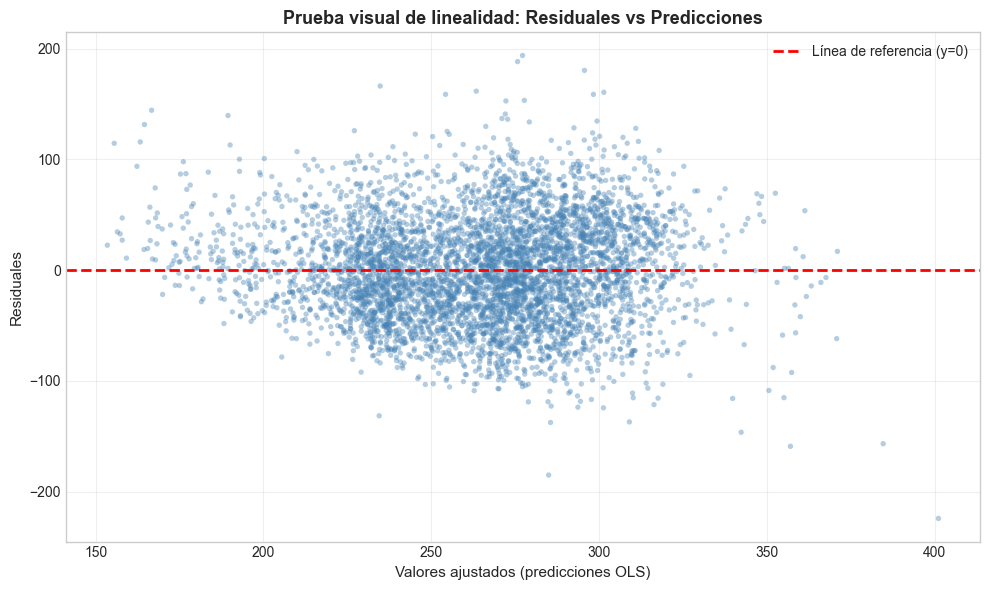


PRUEBA DE LINEALIDAD (OLS)
Muestra utilizada: 5,000 registros
R² ajustado (OLS): 0.3337

--- Pruebas estadísticas ---

Rainbow Test:
  Estadístico = 0.9805
  p-value     = 0.6883

RESET (Ramsey):
  F           = 55.0256
  p-value     = 0.0000

Harvey-Collier:
  No disponible (No se pudo calcular Harvey-Collier (matriz singular): "The initial regressor matrix, x[:skip], issingular. You must use a value of
skip large enough to ensure that the first OLS estimator is well-defined.
)

CONCLUSIÓN
⚠ Las pruebas RESET (p=0.0000) sugieren posible no linealidad (p < 0.05). Esto indica que puede haber patrones no lineales en la relación entre las variables y el puntaje global. Se recomienda considerar: (1) transformaciones de variables, (2) modelos no lineales, o (3) términos de interacción en el modelo lineal.


In [44]:
# Prueba de linealidad (Rainbow, RESET y Harvey-Collier)
def prueba_linealidad(X_scaled: pd.DataFrame, y: pd.Series, sample_size: int = 5000):
    sample = X_scaled.copy()
    sample[TARGET_COL] = y.values
    sample = sample.dropna()
    if len(sample) > sample_size:
        sample = sample.sample(sample_size, random_state=42)
    y_sample = sample[TARGET_COL]
    X_sample = sm.add_constant(sample.drop(columns=[TARGET_COL]), has_constant='add')
    ols_res = sm.OLS(y_sample, X_sample).fit()

    rainbow_stat, rainbow_p = linear_rainbow(ols_res)
    reset_res = linear_reset(ols_res, power=2, use_f=True)

    hc_stat = None
    hc_p = None
    hc_msg = None
    try:
        skip_val = max(10, min(len(sample) - 1, X_sample.shape[1] + 5))
        hc_stat, hc_p = linear_harvey_collier(ols_res, skip=skip_val)
    except ValueError as err:
        hc_msg = f'No se pudo calcular Harvey-Collier (matriz singular): {err}'

    # Visualizacion de residuales
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(ols_res.fittedvalues, ols_res.resid, s=15, alpha=0.4, color='steelblue', edgecolors='none')
    ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Línea de referencia (y=0)')
    ax.set_xlabel('Valores ajustados (predicciones OLS)', fontsize=11)
    ax.set_ylabel('Residuales', fontsize=11)
    ax.set_title('Prueba visual de linealidad: Residuales vs Predicciones', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

    # Resultados de las pruebas
    print('\n' + '='*60)
    print('PRUEBA DE LINEALIDAD (OLS)')
    print('='*60)
    print(f'Muestra utilizada: {len(sample):,} registros')
    print(f'R² ajustado (OLS): {ols_res.rsquared:.4f}')
    print('\n--- Pruebas estadísticas ---')
    print(f'\nRainbow Test:')
    print(f'  Estadístico = {rainbow_stat:.4f}')
    print(f'  p-value     = {rainbow_p:.4f}')
    print(f'\nRESET (Ramsey):')
    print(f'  F           = {float(reset_res.fvalue):.4f}')
    print(f'  p-value     = {float(reset_res.pvalue):.4f}')
    print(f'\nHarvey-Collier:')
    if hc_stat is not None:
        print(f'  t           = {hc_stat:.4f}')
        print(f'  p-value     = {hc_p:.4f}')
    else:
        print(f'  No disponible ({hc_msg})')

    # Interpretacion
    print('\n' + '='*60)
    print('CONCLUSIÓN')
    print('='*60)
    
    # Criterios de interpretacion (alpha = 0.05)
    rainbow_ok = rainbow_p > 0.05
    reset_ok = float(reset_res.pvalue) > 0.05
    hc_ok = (hc_p > 0.05) if hc_p is not None else None
    
    if rainbow_ok and reset_ok and (hc_ok or hc_ok is None):
        conclusion = (
            f"✓ Los resultados de las pruebas estadísticas (Rainbow p={rainbow_p:.4f}, "
            f"RESET p={float(reset_res.pvalue):.4f}"
        )
        if hc_ok:
            conclusion += f", Harvey-Collier p={hc_p:.4f}"
        conclusion += (
            ") NO muestran evidencia significativa de no linealidad (p > 0.05). "
            "Esto indica que la relación entre las variables predictoras y el puntaje global "
            "puede ser adecuadamente modelada mediante regresión lineal. La distribución de "
            "residuales alrededor de cero (gráfica superior) refuerza esta interpretación, "
            "sugiriendo que el modelo lineal captura apropiadamente los patrones en los datos."
        )
    else:
        failing_tests = []
        if not rainbow_ok:
            failing_tests.append(f"Rainbow (p={rainbow_p:.4f})")
        if not reset_ok:
            failing_tests.append(f"RESET (p={float(reset_res.pvalue):.4f})")
        if hc_ok is False:
            failing_tests.append(f"Harvey-Collier (p={hc_p:.4f})")
        
        conclusion = (
            f"⚠ Las pruebas {', '.join(failing_tests)} sugieren posible no linealidad "
            f"(p < 0.05). Esto indica que puede haber patrones no lineales en la relación "
            f"entre las variables y el puntaje global. Se recomienda considerar: "
            f"(1) transformaciones de variables, (2) modelos no lineales, o "
            f"(3) términos de interacción en el modelo lineal."
        )
    
    print(conclusion)
    print('='*60)

    return {
        'r2_ajustado': ols_res.rsquared,
        'rainbow_pvalue': float(rainbow_p),
        'reset_pvalue': float(reset_res.pvalue),
        'harvey_pvalue': float(hc_p) if hc_p is not None else None,
        'n_muestra': len(sample),
    }

linealidad = prueba_linealidad(X_train_scaled, y_train)


ANÁLISIS SHAP: INTERPRETABILIDAD DEL MODELO
SHAP ya instalado

Creando explainer SHAP para Gradient Boosting...
Esto puede tomar varios minutos...

SHAP values calculados para 1000 observaciones
Dimensiones: (1000, 36)

GRÁFICO 1: IMPORTANCIA GLOBAL DE VARIABLES

SHAP values calculados para 1000 observaciones
Dimensiones: (1000, 36)

GRÁFICO 1: IMPORTANCIA GLOBAL DE VARIABLES


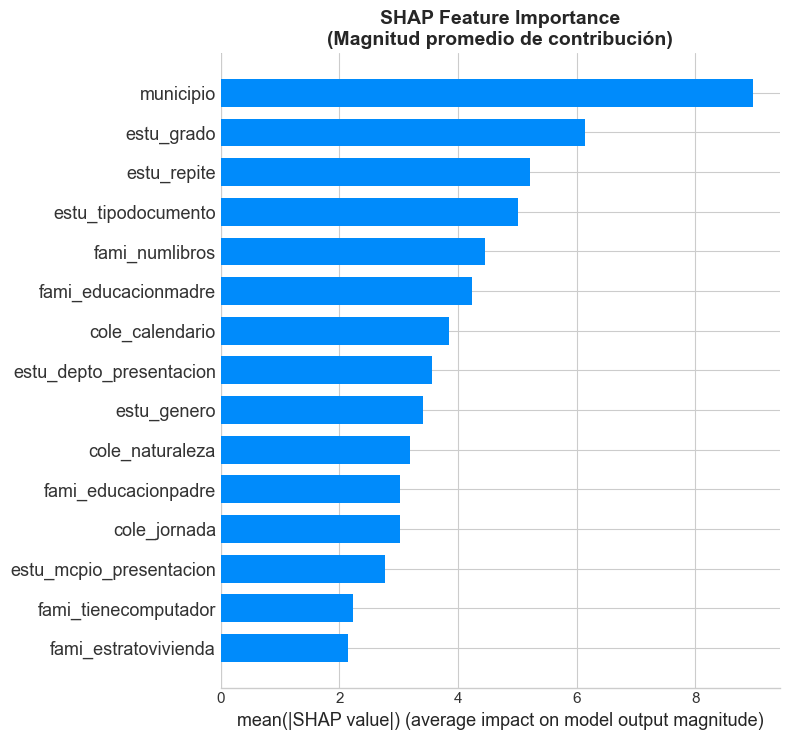


Interpretación:
  • Barras = Promedio de |SHAP value| para cada variable
  • Mayor barra = Mayor impacto promedio en predicciones

GRÁFICO 2: DISTRIBUCIÓN DE EFECTOS (BEESWARM PLOT)


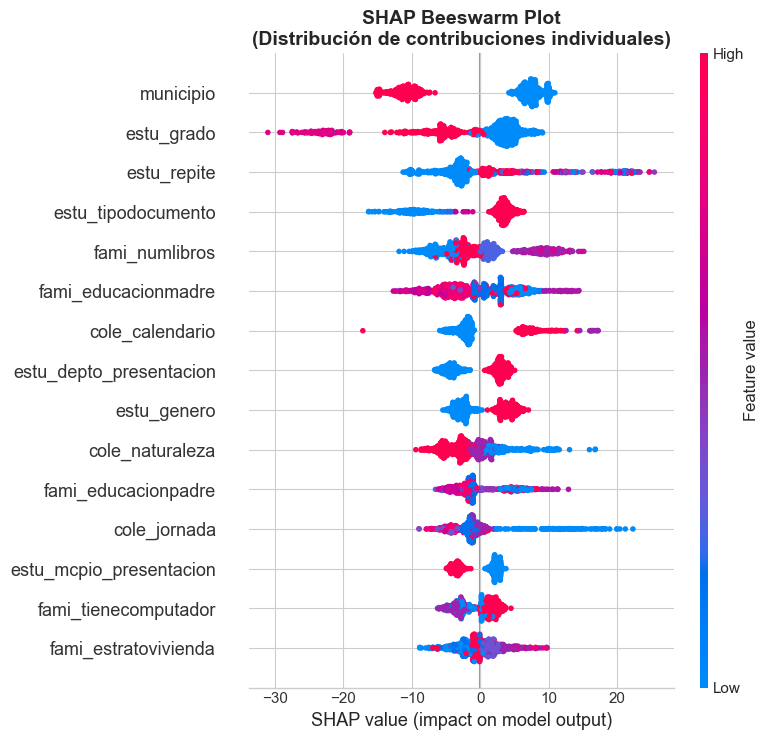


Interpretación:
  • Eje X: Valor SHAP (contribución al puntaje)
  • Eje Y: Variables ordenadas por importancia
  • Color: Valor de la variable (rojo=alto, azul=bajo)
  • Ejemplo: Puntos rojos a la derecha = valores altos aumentan puntaje

Archivos guardados en: C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\artifacts\anexos
  - shap_importance.png
  - shap_beeswarm.png

ANÁLISIS SHAP COMPLETADO


In [45]:
# Analisis SHAP
print("="*70)
print("ANÁLISIS SHAP: INTERPRETABILIDAD DEL MODELO")
print("="*70)

try:
    import shap
    print("SHAP ya instalado")
except ImportError:
    print('SHAP no esta instalado. Ejecuta: pip install shap')
    shap = None

if shap is not None:
    print("\nCreando explainer SHAP para Gradient Boosting...")
    print("Esto puede tomar varios minutos...")
    
    # Muestra para análisis SHAP (computacionalmente costoso)
    sample_size = min(1000, len(X_test))
    X_sample = X_test.sample(sample_size, random_state=42)
    
    explainer = shap.Explainer(gb_model, X_train)
    shap_values = explainer(X_sample)
    
    print(f"\nSHAP values calculados para {sample_size} observaciones")
    print(f"Dimensiones: {shap_values.values.shape}")
    
    # SHAP Summary Plot - Importancia Global
    print(f"\n{'='*70}")
    print("GRÁFICO 1: IMPORTANCIA GLOBAL DE VARIABLES")
    print(f"{'='*70}")
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, plot_type='bar', max_display=15, show=False)
    plt.title('SHAP Feature Importance\n(Magnitud promedio de contribución)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    shap_bar = OUTPUT_DIR / 'shap_importance.png'
    plt.savefig(shap_bar, dpi=150)
    plt.show()
    
    print("\nInterpretación:")
    print("  • Barras = Promedio de |SHAP value| para cada variable")
    print("  • Mayor barra = Mayor impacto promedio en predicciones")
    
    # SHAP Beeswarm Plot - Distribución de efectos
    print(f"\n{'='*70}")
    print("GRÁFICO 2: DISTRIBUCIÓN DE EFECTOS (BEESWARM PLOT)")
    print(f"{'='*70}")
    
    plt.figure(figsize=(10, 10))
    shap.summary_plot(shap_values, X_sample, max_display=15, show=False)
    plt.title('SHAP Beeswarm Plot\n(Distribución de contribuciones individuales)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    shap_bee = OUTPUT_DIR / 'shap_beeswarm.png'
    plt.savefig(shap_bee, dpi=150)
    plt.show()
    
    print("\nInterpretación:")
    print("  • Eje X: Valor SHAP (contribución al puntaje)")
    print("  • Eje Y: Variables ordenadas por importancia")
    print("  • Color: Valor de la variable (rojo=alto, azul=bajo)")
    print("  • Ejemplo: Puntos rojos a la derecha = valores altos aumentan puntaje")
    
    print(f"\nArchivos guardados en: {OUTPUT_DIR.resolve()}")
    print(f"  - {shap_bar.name}")
    print(f"  - {shap_bee.name}")
    
    print("\n" + "="*70)
    print("ANÁLISIS SHAP COMPLETADO")
    print("="*70)
else:
    print("\n[ADVERTENCIA] SHAP no disponible. Instala con: pip install shap")

## 4. SHAP Values: Interpretabilidad Avanzada

### Fundamentos Teóricos

**SHAP (SHapley Additive exPlanations)** cuantifica la contribución de cada variable a cada predicción mediante Teoría de Juegos:

$$\phi_j^{(i)} = \sum_{S \subseteq F \setminus \{j\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S \cup \{j\}}(x^{(i)}) - f_S(x^{(i)})]$$

**Propiedades:**
1. **Eficiencia:** $\sum_{j=1}^{p} \phi_j^{(i)} = f(x^{(i)}) - E[f(X)]$
2. **Simetría:** Variables con igual contribución tienen mismo SHAP
3. **Dummy:** Variables sin aporte tienen SHAP = 0

**Interpretación:**
- SHAP > 0: Variable aumenta el puntaje
- SHAP < 0: Variable disminuye el puntaje
- |SHAP|: Magnitud de la contribución

In [46]:
# Entrenamiento de Gradient Boosting para analisis SHAP
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("="*70)
print("ENTRENAMIENTO: GRADIENT BOOSTING PARA ANÁLISIS SHAP")
print("="*70)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    subsample=0.8,
    random_state=42,
)

print("\nEntrenando Gradient Boosting...")
gb_model.fit(X_train, y_train)

y_pred_test_gb = gb_model.predict(X_test)
y_pred_train_gb = gb_model.predict(X_train)

def resumen_metricas(y_true, y_pred):
    return {
        'r2': r2_score(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
    }

gb_train = resumen_metricas(y_train, y_pred_train_gb)
gb_test = resumen_metricas(y_test, y_pred_test_gb)

print(f"\n{'CONJUNTO':<15} {'R²':>10} {'RMSE':>10} {'MAE':>10}")
print(f"{'-'*45}")
print(f"{'Entrenamiento':<15} {gb_train['r2']:>10.4f} {gb_train['rmse']:>10.2f} {gb_train['mae']:>10.2f}")
print(f"{'Prueba':<15} {gb_test['r2']:>10.4f} {gb_test['rmse']:>10.2f} {gb_test['mae']:>10.2f}")

print(f"\nModelo entrenado y listo para análisis SHAP")

ENTRENAMIENTO: GRADIENT BOOSTING PARA ANÁLISIS SHAP

Entrenando Gradient Boosting...

CONJUNTO                R²       RMSE        MAE
---------------------------------------------
Entrenamiento       0.4518      41.29      32.93
Prueba              0.4372      41.83      33.32

Modelo entrenado y listo para análisis SHAP

CONJUNTO                R²       RMSE        MAE
---------------------------------------------
Entrenamiento       0.4518      41.29      32.93
Prueba              0.4372      41.83      33.32

Modelo entrenado y listo para análisis SHAP


## 3. Análisis SHAP con Gradient Boosting

Para el análisis de interpretabilidad, entrenamos un modelo Gradient Boosting (el mejor modelo según resultados del notebook Modelos.ipynb) y aplicamos SHAP Values para entender la contribución de cada variable.

ANÁLISIS SHAP: APERTURA DE LA CAJA NEGRA
SHAP ya instalado

Creando explainer SHAP para Gradient Boosting...
Esto puede tomar varios minutos...

SHAP values calculados para 1000 observaciones
Dimensiones: (1000, 36)

GRÁFICO 1: IMPORTANCIA GLOBAL DE VARIABLES

SHAP values calculados para 1000 observaciones
Dimensiones: (1000, 36)

GRÁFICO 1: IMPORTANCIA GLOBAL DE VARIABLES


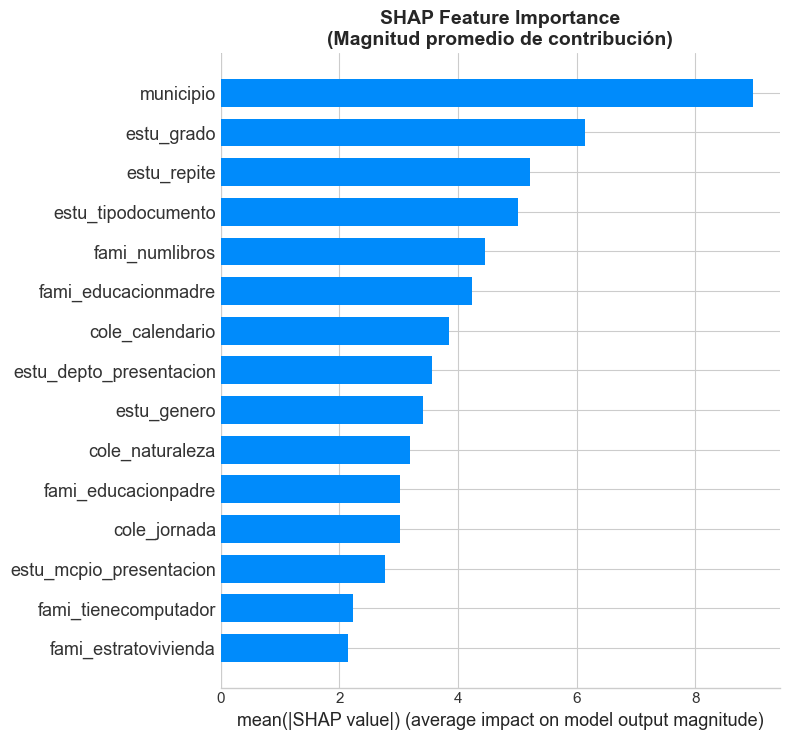


Interpretación:
  • Barras = Promedio de |SHAP value| para cada variable
  • Mayor barra = Mayor impacto promedio en predicciones

GRÁFICO 2: DISTRIBUCIÓN DE EFECTOS (BEESWARM PLOT)


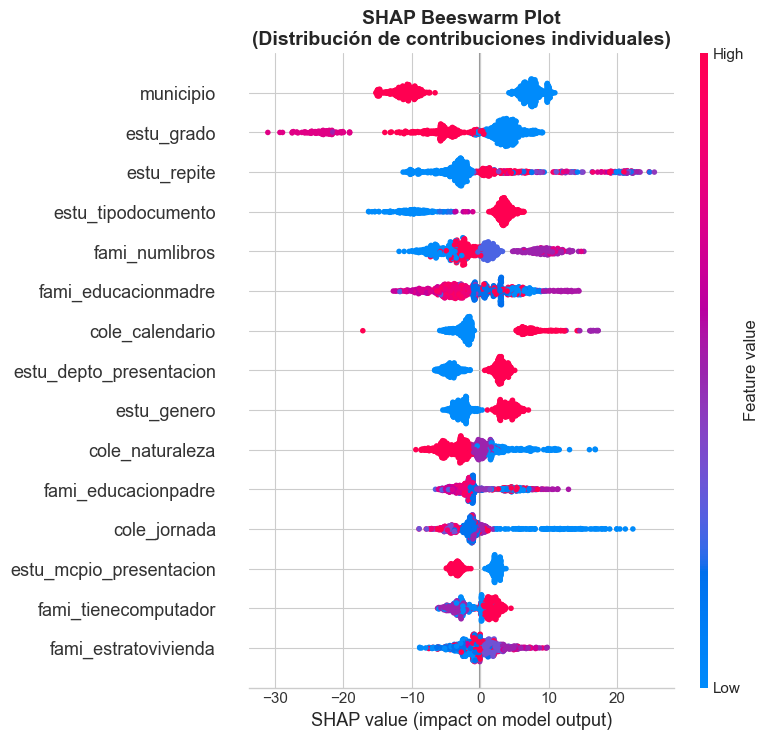


Interpretación:
  • Eje X: Valor SHAP (contribución al puntaje)
  • Eje Y: Variables ordenadas por importancia
  • Color: Valor de la variable (rojo=alto, azul=bajo)
  • Ejemplo: Puntos rojos a la derecha = valores altos aumentan puntaje

Archivos guardados en: C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\artifacts\anexos
  - shap_importance.png
  - shap_beeswarm.png


In [47]:
# Analisis SHAP
print("="*70)
print("ANÁLISIS SHAP: APERTURA DE LA CAJA NEGRA")
print("="*70)

try:
    import shap
    print("SHAP ya instalado")
except ImportError:
    print('SHAP no esta instalado. Ejecuta: pip install shap')
    shap = None

if shap is not None:
    print("\nCreando explainer SHAP para Gradient Boosting...")
    print("Esto puede tomar varios minutos...")
    
    # Muestra para análisis SHAP (computacionalmente costoso)
    sample_size = min(1000, len(X_test))
    X_sample = X_test.sample(sample_size, random_state=42)
    
    explainer = shap.Explainer(gb_model, X_train)
    shap_values = explainer(X_sample)
    
    print(f"\nSHAP values calculados para {sample_size} observaciones")
    print(f"Dimensiones: {shap_values.values.shape}")
    
    # SHAP Summary Plot - Importancia Global
    print(f"\n{'='*70}")
    print("GRÁFICO 1: IMPORTANCIA GLOBAL DE VARIABLES")
    print(f"{'='*70}")
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, plot_type='bar', max_display=15, show=False)
    plt.title('SHAP Feature Importance\n(Magnitud promedio de contribución)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    shap_bar = OUTPUT_DIR / 'shap_importance.png'
    plt.savefig(shap_bar, dpi=150)
    plt.show()
    
    print("\nInterpretación:")
    print("  • Barras = Promedio de |SHAP value| para cada variable")
    print("  • Mayor barra = Mayor impacto promedio en predicciones")
    
    # SHAP Beeswarm Plot - Distribución de efectos
    print(f"\n{'='*70}")
    print("GRÁFICO 2: DISTRIBUCIÓN DE EFECTOS (BEESWARM PLOT)")
    print(f"{'='*70}")
    
    plt.figure(figsize=(10, 10))
    shap.summary_plot(shap_values, X_sample, max_display=15, show=False)
    plt.title('SHAP Beeswarm Plot\n(Distribución de contribuciones individuales)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    shap_bee = OUTPUT_DIR / 'shap_beeswarm.png'
    plt.savefig(shap_bee, dpi=150)
    plt.show()
    
    print("\nInterpretación:")
    print("  • Eje X: Valor SHAP (contribución al puntaje)")
    print("  • Eje Y: Variables ordenadas por importancia")
    print("  • Color: Valor de la variable (rojo=alto, azul=bajo)")
    print("  • Ejemplo: Puntos rojos a la derecha = valores altos aumentan puntaje")
    
    print(f"\nArchivos guardados en: {OUTPUT_DIR.resolve()}")
    print(f"  - {shap_bar.name}")
    print(f"  - {shap_bee.name}")
else:
    print("\n[ADVERTENCIA] SHAP no disponible. Instala con: pip install shap")